# MCPRO > Simulation d'un régulateur de vitesse de véhicule (n° 2)
L'objectif de cet exercice est de **réussir à régler un régulateur PID** de façon satisfaisante pour la régulation de vitesse d'un véhicule (cruise control en anglais).
Dans un contexte prédéfini (véhicule donné et consigne de vitesse donnée), vous devez rechercher des valeurs "optimales" des paramètres du régulateur PID, c'est-à-dire : $k_P$, $k_I$, et $k_D$.

Vous pouvez faire autant d'essais que vous le souhaitez, à vous de noter (éventuellement) les valeurs entre chaque tentative. Pour chaque tentative, le simulateur vous renverra un score qui doit être le plus élevé possible, et des graphiques montrant l'évolution des variables au cours du temps. Le score prend en compte différentes caractéristiques du résultat, et les graphiques peuvent vous aider à comprendre comment l'améliorer.

## Comment procéder ?
La page que vous consultez est un "notebook jupyter". Il s'agit d'un document interactif composé de "cellules" qui contiennent du texte (comme ce paragraphe par exemple) ou du code informatique (en langage Matlab/Octave dans le cas présent). Vous devrez modifier ce code (uniquement pour indiquer de nouvelles valeurs des paramètres du régulateur PID), puis l'exécuter pour obtenir de nouveaux résultats.

### 1ère étape (à faire une seule fois) : initialiser le code
Vous ne devez réaliser cette première étape qu'une seule fois (mais à chaque fois que vous ouvrez ou rouvrez ce notebook).
1. Cliquez dans la première cellule de code (ci-dessous) --> une barre verticale bleue s'affiche à sa gauche, indiquant qu'elle est sélectionnée.
2. Exécutez le code de cette cellule en cliquant sur `Run`![Image](images/run.png) dans la barre d'outils en haut de cette page, ou bien en appuyant sur les touches `maj`+`entrée`.

Ne supprimez pas cette cellule, et ne modifiez pas son contenu !

In [4]:
%------------------------------------------------------------------------------------------
% Première cellule de code
%------------------------------------------------------------------------------------------
% Ne modifiez PAS le contenu de cette cellule, mais exécutez-là une fois (bouton run)
%------------------------------------------------------------------------------------------

% Fonction de simulation du système en boucle fermée. Reçoit les paramètres du régulateur PID testé, et affiche les résultats.
function simulateCloseLoop(k)

    controller.kp = k(1);
    controller.ki = k(2);
    controller.kd = k(3);

    % Caractéristiques du procédé contrôlé (véhicule)
    process.name = 'Renault Clio 4 0.9 TC';
    process.model.vmax = 182; % Vitesse maximum (km/h)
    process.model.t100 = 13.3; % Temps de 0 à 100 km/h (s)

    % Définition de la consigne (vitesse cible) sous forme d'échelons
    setpoint.time = [0, 120, 240, 360]; % Temps (s)
    setpoint.value = [0, 80, 130, 80]; % Vitesse (km/h)

    % Paramètres de la simulation
    % Paramètres de la simulation
    N = 361; % Nombre de points
    tend = setpoint.time(end); 
    t = linspace(0, tend, N);
    dt = t(2)-t(1); 

    % Caractéristiques du procédé (véhicule)
    process.input.min = 0;
    process.input.max = 100;

    % Calcul des coefficients du modèle (continu et discret)
    tau = -process.model.t100/log(1-100/process.model.vmax); % Constante de temps (s)
    K = process.model.vmax; % Gain statique (km/h/%)
    process.model.a = exp(-dt/tau); % Coefficient de l'équation aux différences
    process.model.b = K*(1-process.model.a)/(process.input.max-process.input.min); % Coefficient de l'équation aux différences

    % Valeurs initiales des variables
    controller.e = 0; controller.se = 0;
    u = zeros(size(t)); y = zeros(size(t));
    w = interp1(setpoint.time, setpoint.value, t, 'next', setpoint.value(end));

    % Fonction de calcul de la sortie du régulateur (entrée du procédé)
    function [value, controller] = calculateController(process, controller, w, y, step)
        e = w - y;
        controller.se = controller.se + e*step;
        de = (e-controller.e)/step;
        controller.e = e;

        value = controller.kp*controller.e + controller.ki*controller.se + controller.kd*de;
        value = max(min(value, process.input.max), process.input.min);
    end

    % Boucle principale de calcul
    for i=2:length(t)

        % Calcul de la sortie du procédé (vitesse réelle) à l'instant t
        y(i) = process.model.a*y(i-1) + process.model.b*u(i-1);

        % Calcul de la sortie du régulateur -> entrée du procédé (taux d'accélération)
        [value, controller] = calculateController(process, controller, w(i), y(i), dt);
        u(i) = value;
    end

    % Calcul du score
    score = round(10*max(0, sum(abs(w))/sum(abs(w-y)) + 1000*mean(u)/sum(abs(mean(u)-u)) - 1000*length(find(u<=process.input.min | u>=process.input.max))/length(t)));
    
    % Affichage du résultat
    disp(sprintf('kp = %.2f,  ki = %.2f,  kd  = %.2f  -->  Score = %d', controller.kp, controller.ki, controller.kd, score))

    % Tracé des courbes
    subplot(2,1,1); plot(t,u)
    xlabel('temps (s)')
    ylabel('position accelerateur (%)')
    title(process.name)
    subplot(2,1,2); plot(t,w,t,y)
    xlabel('temps (s)')
    ylabel('vitesse (km/h)')
    legend('consigne', 'mesure')

end

### 2ème étape : modifier les valeurs des paramètres du régulateur
1. Dans la deuxième cellule de code (ci-dessous), modifiez les valeurs des variables `kp`, `ki`, `kd`, qui correspondent respectivement aux paramètres $k_P$, $k_I$, et $k_D$ du régulateur PID. Les valeurs initiales fournies sont arbitraires.
2. Exécutez le code de cette cellule (lorsqu'elle est sélectionnée) en cliquant sur `Run`![Image](images/run.png) dans la barre d'outils, ou bien en appuyant sur les touches `maj`+`entrée`.
3. Observez le résultat (score et graphiques), et recommencez jusqu'à ce que le résultat vous paraisse satisfaisant.

Si vous obtenez le message d'erreur `error: 'simulateCloseLoop' undefined` au lieu de résultats, c'est que vous n'avez pas réalisé la première étape.

Note : il est possible que vous obteniez un score de 0 alors qu'il vous semble que la régulation est correcte. Il y a toujours une raison ! Essayez de comprendre ce qui ne va pas d'après les graphiques, et réajustez les paramètres du régulateur en conséquence.

kp = 1.00,  ki = 1.00,  kd  = 1.00  -->  Score = 0


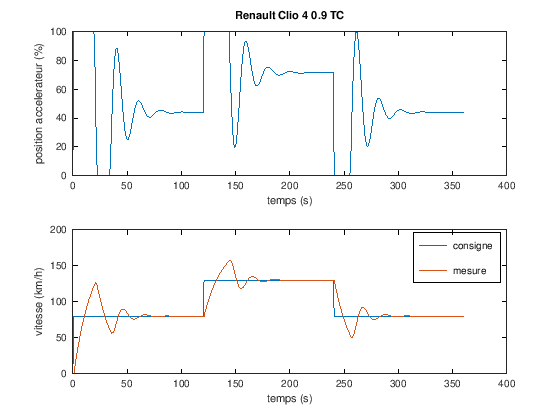

In [5]:
%------------------------------------------------------------------------------------------
% Deuxième cellule de code
%------------------------------------------------------------------------------------------
% Vous DEVEZ modifier les valeurs de kp, ki, kd dans cette cellule puis l'exécuter (run)
% pour calculer et afficher les résultats (qui apparaîtront en dessous de la cellule) 
%------------------------------------------------------------------------------------------
clear 

% Paramètres du régulateur PID
kp = 1.0;
ki = 1.0;
kd = 1.0;

%------------------------------------------------------------------------------------------
% Ne modifiez PAS ce qui suit
%------------------------------------------------------------------------------------------
% Lancement de la simulation
simulateCloseLoop([kp, ki, kd]);

### 3ème étape : conserver et soumettre votre meilleur résultat
Vous pouvez interrompre vos tentatives à tout moment et recommencer plus tard. Avant de fermer le notebook, enregistrez les modifications en cliquant sur `Save`![Image](images/save.png) (raccourci clavier : `ctrl`+`S`).

Lorsque vous pensez avoir obtenu le meilleur résultat possible : revenez sur __[la page Moodle MCPRO](https://moodle.bordeaux-inp.fr/course/view.php?id=4&section=3)__, ouvrez le formulaire "__[Réglage d'un régulateur PID : vos réponses](https://moodle.bordeaux-inp.fr/mod/questionnaire/view.php?id=51272)__", et inscrivez vos valeurs de $k_P$, $k_I$, $k_D$, et du score, **sur la deuxième page** du formulaire. Vous pouvez enregistrer ce formulaire est y revenir plus tard, avant de le soumettre définitivement.